In [1]:
import pandas as pd
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import numpy as np

# this is the package used to query the runoff data
!pip install hydrofunctions
import hydrofunctions as hf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
     |████████████████████████████████| 7.8 MB 26.7 MB/s 
     |████████████████████████████████| 16.6 MB 116 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 659 kB/s 
     |████████████████████████████████| 1.6 MB 6.5 MB/s 


Import basins data

In [2]:
basins = gpd.read_file('https://raw.githubusercontent.com/gee-hydro/PML.R/master/validation/PML_validation_sitelist.zip').rename(columns={'RUNOFF_MM_':'RUNOFF_MM_YR'}).to_crs('EPSG:4326')

In [3]:
basins.head()

,SITE_NO,SQMI,ABS_DIFF,STAID,LAT_GAGE,LNG_GAGE,RUNOFF_MM_YR,PPT_MM_YR,ET_EST_MM_,geometry
0,05014500,30.783097,0.003783,5014500,48.799145,-113.656776,966.11150,2086.5420,1120.43050,"POLYGON ((-113.76216 48.80802, -113.76224 48.8..."
1,05083600,52.899793,0.109010,5083600,48.247220,-98.117044,25.11367,478.7508,453.63713,"POLYGON ((-98.26987 48.54921, -98.26986 48.548..."
2,05483000,23.343336,0.027361,5483000,42.107481,-94.370246,214.00000,837.5916,623.59160,"POLYGON ((-94.35575 42.18825, -94.35576 42.187..."
3,06006000,38.088726,0.028349,6006000,44.615474,-111.629130,110.99100,956.7892,845.79820,"POLYGON ((-111.58197 44.63617, -111.58203 44.6..."
4,06036905,261.346882,0.073238,6036905,44.620210,-110.862990,304.26440,955.8911,651.62670,"POLYGON ((-110.69583 44.66260, -110.69589 44.6..."


Use hydrofunctions to query USGS streamflow data through NWIS

In [4]:
runoff_data = hf.NWIS( # function to query NWIS database
                      basins.SITE_NO.values[0], # site id number
                      service = 'dv', # can choose 'dv' for daily data or 'iv' for 15 min (instantaneous) data
                      start_date = '1980-10-01', # start date for getting data
                      end_date = '2020-10-01', # end date for getting data
                      parameterCd = '00060', # parameter code--'00060' is streamflow in ft3/s, see all here: https://help.waterdata.usgs.gov/codes-and-parameters/parameter
)

runoff_data = runoff_data.df() # turns the output into a pandas dataframe

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=05014500&parameterCd=00060&startDT=1980-10-01&endDT=2020-10-01


In [6]:
runoff_data.head()
# the first column is the data, and the second column is quality parameters

,USGS:05014500:00060:00003,USGS:05014500:00060:00003_qualifiers
datetimeUTC,,
1980-10-01 00:00:00+00:00,101.0,A
1980-10-02 00:00:00+00:00,94.0,A
1980-10-03 00:00:00+00:00,87.0,A
1980-10-04 00:00:00+00:00,80.0,A
1980-10-05 00:00:00+00:00,75.0,A


In [11]:
# rename columns to something sensible
cols = runoff_data.columns
runoff_data.rename(columns={cols[0]:'discharge_ft3_s',
                            cols[1]:'qualifiers'}, 
                   inplace=True)

# use basin area to convert to mm/day
basin_area = basins.SQMI.values[0]*2.58999 # basin area in km2

runoff_data['discharge_mm_per_day'] = runoff_data.discharge_ft3_s*2.83168e-11/basin_area*10e6*3600*24

In [26]:
plt.rcParams.update({'font.size': 22})

Text(0, 0.5, 'Streamflow (mm/day)')

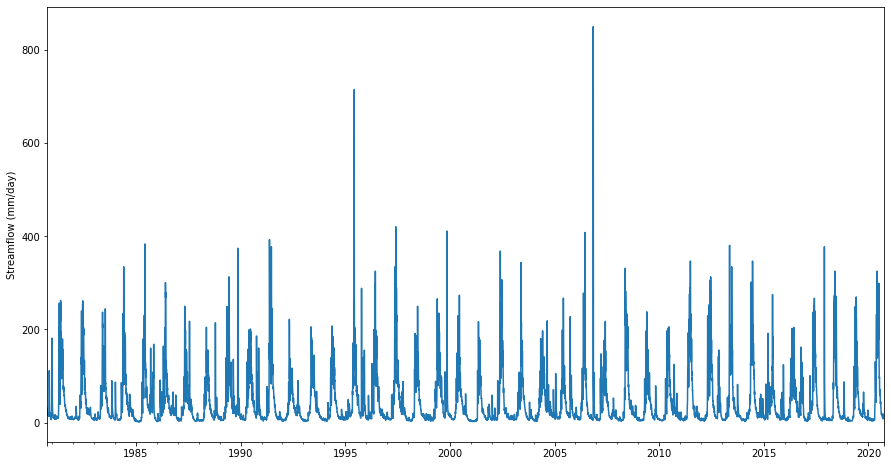

In [28]:
%matplotlib inline
fig,ax = plt.subplots(1,figsize = (15,8))
runoff_data.discharge_mm_per_day.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Streamflow (mm/day)')